In [2]:
#   GPU환경
import torch
import torch.nn as nn
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import torchvision
from torchvision.models import DenseNet121_Weights
from torch import optim
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support
#   문서
import pandas as pd
import numpy as np
import os
from tabulate import tabulate
from sklearn.metrics import classification_report

#   이미지
import cv2
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt

print("ChexPert")

ChexPert


In [3]:
disease_list = ['No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
                'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
                'Atelectasis', 'Pneumothorax', 'Pleural Effusion', 'Pleural Other',
                'Fracture', 'Support Devices']


train_df = pd.read_csv('pert_train_dataset.csv')
print("Train Data:",len(train_df))

train_df.replace(-1, 2, inplace=True)
train_df.fillna(0, inplace=True)

results = {disease: {'Uncertain': 0, 'Positive': 0, 'Negative': 0} for disease in disease_list}

for disease in disease_list:
    results[disease]['Positive'] = (train_df[disease] == 1).sum()
    results[disease]['Negative'] = (train_df[disease] == 0).sum()
    results[disease]['Uncertain'] = (train_df[disease] == 2).sum()
results_df = pd.DataFrame(results).T

# 각 질병별 값의 총합계 계산
results_df['Total'] = results_df.sum(axis=1)

# 총합계가 포함된 표 출력
print("Train set:")
print(tabulate(results_df, headers='keys'))

Train Data: 96492
Train set:
                              Uncertain    Positive    Negative    Total
--------------------------  -----------  ----------  ----------  -------
No Finding                            0       22911       73581    96492
Enlarged Cardiomediastinum        13481        9445       73566    96492
Cardiomegaly                       2400       24528       69564    96492
Lung Opacity                       1505       31326       63661    96492
Lung Lesion                         574        4150       91768    96492
Edema                              5829        9590       81073    96492
Consolidation                      3521        3954       89017    96492
Pneumonia                         11069        7418       78005    96492
Atelectasis                        5191       21629       69672    96492
Pneumothorax                       1177        3166       92149    96492
Pleural Effusion                   3684       18200       74608    96492
Pleural Other         

In [4]:
valid_df = pd.read_csv('pert_valid_dataset.csv')
print("Valid Data:",len(valid_df))

valid_df.replace(-1, 2, inplace=True)
valid_df.fillna(0, inplace=True)

results = {disease: {'Uncertain': 0, 'Positive': 0, 'Negative': 0} for disease in disease_list}

for disease in disease_list:
    results[disease]['Positive'] = (valid_df[disease] == 1).sum()
    results[disease]['Negative'] = (valid_df[disease] == 0).sum()
    results[disease]['Uncertain'] = (valid_df[disease] == 2).sum()
results_df = pd.DataFrame(results).T    

# 각 질병별 값의 총합계 계산
results_df['Total'] = results_df.sum(axis=1)

# 총합계가 포함된 표 출력
print("Valid set:")
print(tabulate(results_df, headers='keys'))


Valid Data: 24123
Valid set:
                              Uncertain    Positive    Negative    Total
--------------------------  -----------  ----------  ----------  -------
No Finding                            0        5771       18352    24123
Enlarged Cardiomediastinum         3493        2350       18280    24123
Cardiomegaly                        582        6140       17401    24123
Lung Opacity                        397        7798       15928    24123
Lung Lesion                         141        1015       22967    24123
Edema                              1446        2389       20288    24123
Consolidation                       836        1061       22226    24123
Pneumonia                          2779        1877       19467    24123
Atelectasis                        1301        5351       17471    24123
Pneumothorax                        290         760       23073    24123
Pleural Effusion                    936        4483       18704    24123
Pleural Other         

In [5]:
test_df = pd.read_csv('pert_test_dataset.csv')
print("Test Data:",len(test_df))

test_df.replace(-1, 2, inplace=True)
test_df.fillna(0, inplace=True)

results = {disease: {'Uncertain': 0, 'Positive': 0, 'Negative': 0 } for disease in disease_list}

for disease in disease_list:
    results[disease]['Positive'] = (train_df[disease] == 1).sum()
    results[disease]['Negative'] = (train_df[disease] == 0).sum()
    results[disease]['Uncertain'] = (train_df[disease] == 2).sum()
results_df = pd.DataFrame(results).T

# 각 질병별 값의 총합계 계산
results_df['Total'] = results_df.sum(axis=1)

# 총합계가 포함된 표 출력
print("Test set:")
print(tabulate(results_df, headers='keys'))


Test Data: 675
Test set:
                              Uncertain    Positive    Negative    Total
--------------------------  -----------  ----------  ----------  -------
No Finding                            0       22911       73581    96492
Enlarged Cardiomediastinum        13481        9445       73566    96492
Cardiomegaly                       2400       24528       69564    96492
Lung Opacity                       1505       31326       63661    96492
Lung Lesion                         574        4150       91768    96492
Edema                              5829        9590       81073    96492
Consolidation                      3521        3954       89017    96492
Pneumonia                         11069        7418       78005    96492
Atelectasis                        5191       21629       69672    96492
Pneumothorax                       1177        3166       92149    96492
Pleural Effusion                   3684       18200       74608    96492
Pleural Other             

In [6]:
img_dir = 'Little_dataset/'

# 커스텀 데이터셋 클래스 정의
class Custom_Dataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.target_columns = [
            'No Finding', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion',
            'Enlarged Cardiomediastinum', 'Lung Lesion', 'Lung Opacity', 'Pneumonia', 'Pneumothorax',
            'Pleural Other', 'Fracture', 'Support Devices'
        ]

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        dicom_id = self.dataframe.iloc[idx]['dicom_id']
        img_path = os.path.join(self.img_dir, dicom_id + '.jpg')
        
        try:
            image = Image.open(img_path).convert("RGB")
        except FileNotFoundError:
            print(f"Error: File {img_path} not found.")
            return None, None
        
        if self.transform:
            image = self.transform(image)
        
        try:
            label = self.dataframe.loc[idx, self.target_columns].values.astype('int64')
        except KeyError as e:
            print(f"Error: {e} - Check if target columns are correctly named in the dataframe.")
            return image, None
        
        label = torch.tensor(label)

        return image, label

# 변환 정의
#   Data augmentation 
#   Data Normalization
transform = transforms.Compose(
    [
        transforms.Resize((320, 320)),
        transforms.ToTensor(),
    ]
)

In [7]:
train_dataset = Custom_Dataset(train_df, img_dir, transform=transform)
valid_dataset = Custom_Dataset(valid_df , img_dir, transform=transform)
test_dataset = Custom_Dataset(test_df, img_dir, transform=transform)
print(f"Train : {len(train_dataset)}, Valid : {len(valid_dataset)}, Test : {len(test_dataset)}")


train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Train : 96492, Valid : 24123, Test : 675


In [9]:
class DenseNet121(nn.Module):
    def __init__(self, num_classes=14, is_trained=False):
        super().__init__()
        self.num_classes = num_classes
        if is_trained:
            self.net = torchvision.models.densenet121(weights=DenseNet121_Weights.IMAGENET1K_V1)
        else:
            self.net = torchvision.models.densenet121(weights=None)
            
        kernel_count = self.net.classifier.in_features
        
        # 각 질병에 대해 3개의 출력을 가지도록 수정
        self.net.classifier = nn.Linear(kernel_count, num_classes * 3)
        
    def forward(self, inputs):
        outputs = self.net(inputs)
        # 출력 크기를 (batch_size, num_classes, 3)로 변경
        outputs = outputs.view(-1, self.num_classes, 3)
        
        return outputs

def initialize_model(num_classes=14, use_pretrained=True):
    model = DenseNet121(num_classes=num_classes, is_trained=use_pretrained)
    return model

# 모델 초기화
use_pretrained = True
model = initialize_model(num_classes=14, use_pretrained=use_pretrained)

# GPU 사용 여부 확인 및 모델 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    model = model.to(device)
else:
    print('CANNOT USE GPU')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, betas=(0.9, 0.999))

In [10]:
# 체크포인트 저장 경로
checkpoint_dir = 'checkpoints/ChexPert'
os.makedirs(checkpoint_dir, exist_ok=True)
num_epochs = 4

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", leave=False)
    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        #   (barch_size, number of label, each label value=3)
        outputs = model(images)
        loss = criterion(outputs.view(-1, 3), labels.view(-1))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        train_loader_tqdm.set_description(f"Epoch {epoch+1}/{num_epochs} - Training (loss: {running_loss / (train_loader_tqdm.n + 1):.4f})")
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")

    # 검증
    model.eval()
    valid_loss = 0.0
    all_labels = []
    all_predictions = []
    
    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Validation", leave=False)
    with torch.no_grad():
        for images, labels in val_loader_tqdm:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs.view(-1, 3), labels.view(-1))
            valid_loss += loss.item()
            
            _, predicted = torch.max(outputs, 2)
            all_labels.extend(labels.cpu().numpy().flatten())
            all_predictions.extend(predicted.cpu().numpy().flatten())
    
    valid_loss /= len(val_loader)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='weighted')
    valid_accuracy = 100 * (sum([p == l for p, l in zip(all_predictions, all_labels)]) / len(all_labels))
    
    print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_accuracy:.2f}%")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    
    # 체크포인트 저장
    checkpoint_path = os.path.join(checkpoint_dir, f'chexpert_checkpoint_epoch_{epoch+1}.pth')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': running_loss / len(train_loader),
        'valid_loss': valid_loss,
        'valid_accuracy': valid_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
    }, checkpoint_path)

print("Training complete.")

Epoch 1/4, Loss: 0.3967


Validation Loss: 0.3846, Validation Accuracy: 85.93%
Precision: 0.8361, Recall: 0.8593, F1-Score: 0.8344


Epoch 2/4, Loss: 0.3766


Validation Loss: 0.3771, Validation Accuracy: 86.18%
Precision: 0.8343, Recall: 0.8618, F1-Score: 0.8360


Epoch 3/4, Loss: 0.3664


Validation Loss: 0.3733, Validation Accuracy: 86.39%
Precision: 0.8361, Recall: 0.8639, F1-Score: 0.8388


Epoch 4/4, Loss: 0.3562


Validation Loss: 0.3719, Validation Accuracy: 86.46%
Precision: 0.8369, Recall: 0.8646, F1-Score: 0.8420
Training complete.


In [12]:
from torch.nn.functional import softmax
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# 모델 초기화
use_pretrained = False
model = initialize_model(num_classes=14, use_pretrained=use_pretrained)  # num_classes=5로 설정

# 체크포인트 로드
checkpoint = torch.load('checkpoints/ChexPert/chexpert_checkpoint_epoch_4.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 예측값과 실제값 저장할 리스트 초기화
all_labels_pos = []
all_preds_pos = []

# 테스트 데이터셋에 대한 예측 수행
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)  # 입력 데이터를 GPU로 이동
        labels = labels.to(device)  # 레이블을 GPU로 이동

        # ground-truth 값에서 2를 positive(1)로 설정
        labels_pos = torch.where(labels == 2, torch.tensor(1, device=device), labels)

        outputs = model(inputs)  # outputs 크기: [batch_size, 5, 3]

        # 각 레이블에 대해 positive(p1)에 대한 softmax 적용
        probs = []
        for i in range(14):  # 14개의 레이블에 대해 수행
            prob = softmax(outputs[:, i, :], dim=1)  # 각 레이블에 대해 softmax 적용
            probs.append(prob)  # 모든 확률 저장

        preds = torch.stack(probs, dim=1)  # 각 레이블에 대한 예측 확률을 stack
        positive_probs = preds[:, :, 1]  # positive(p1)의 확률만 저장

        positive_preds = (positive_probs > 0.5).long()  # 0.5를 기준으로 binary 예측

        all_labels_pos.extend(labels_pos.cpu().numpy())
        all_preds_pos.extend(positive_preds.cpu().numpy())

# 각 레이블별 평가 지표 계산
labels = [
            'No Finding', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion',
            'Enlarged Cardiomediastinum', 'Lung Lesion', 'Lung Opacity', 'Pneumonia', 'Pneumothorax',
            'Pleural Other', 'Fracture', 'Support Devices'
        ]

precisions_pos = []
recalls_pos = []
f1s_pos = []
accuracies_pos = []

for i in range(14):  # 각 클래스별로 평가 지표를 계산
    # Positive 평가 지표
    true_binary_pos = [label[i] for label in all_labels_pos]
    pos_pred_binary = [pred[i] for pred in all_preds_pos]
    precisions_pos.append(precision_score(true_binary_pos, pos_pred_binary, average='binary', zero_division=0))
    recalls_pos.append(recall_score(true_binary_pos, pos_pred_binary, average='binary', zero_division=0))
    f1s_pos.append(f1_score(true_binary_pos, pos_pred_binary, average='binary', zero_division=0))
    accuracies_pos.append(accuracy_score(true_binary_pos, pos_pred_binary))

# 각 레이블별 평가 지표 출력
for i, label in enumerate(labels[:]):  # 14개의 레이블만 확인
    print(f"{label} - Positive\n Accuracy: {accuracies_pos[i]:.4f}, Precision: {precisions_pos[i]:.4f}, Recall: {recalls_pos[i]:.4f}, F1-Score: {f1s_pos[i]:.4f}")



No Finding - Positive
 Accuracy: 0.9556, Precision: 0.5000, Recall: 0.2000, F1-Score: 0.2857
Atelectasis - Positive
 Accuracy: 0.6785, Precision: 0.5439, Recall: 0.5232, F1-Score: 0.5333
Cardiomegaly - Positive
 Accuracy: 0.7452, Precision: 0.5649, Recall: 0.3915, F1-Score: 0.4625
Consolidation - Positive
 Accuracy: 0.8800, Precision: 0.5556, Recall: 0.0610, F1-Score: 0.1099
Edema - Positive
 Accuracy: 0.7896, Precision: 0.8571, Recall: 0.2093, F1-Score: 0.3364
Pleural Effusion - Positive
 Accuracy: 0.8104, Precision: 0.8314, Recall: 0.7138, F1-Score: 0.7681
Enlarged Cardiomediastinum - Positive
 Accuracy: 0.8770, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Lung Lesion - Positive
 Accuracy: 0.9052, Precision: 0.4000, Recall: 0.0317, F1-Score: 0.0588
Lung Opacity - Positive
 Accuracy: 0.6193, Precision: 0.3610, Recall: 0.6647, F1-Score: 0.4679
Pneumonia - Positive
 Accuracy: 0.7970, Precision: 0.7143, Recall: 0.0699, F1-Score: 0.1274
Pneumothorax - Positive
 Accuracy: 0.9230, Pr

No Finding - Positive
 Accuracy: 0.9556, Precision: 0.5000, Recall: 0.2000, F1-Score: 0.2857
Atelectasis - Positive
 Accuracy: 0.6785, Precision: 0.5439, Recall: 0.5232, F1-Score: 0.5333
Cardiomegaly - Positive
 Accuracy: 0.7452, Precision: 0.5649, Recall: 0.3915, F1-Score: 0.4625
Consolidation - Positive
 Accuracy: 0.8800, Precision: 0.5556, Recall: 0.0610, F1-Score: 0.1099
Edema - Positive
 Accuracy: 0.7896, Precision: 0.8571, Recall: 0.2093, F1-Score: 0.3364
Pleural Effusion - Positive
 Accuracy: 0.8104, Precision: 0.8314, Recall: 0.7138, F1-Score: 0.7681
Enlarged Cardiomediastinum - Positive
 Accuracy: 0.8770, Precision: 0.0000, Recall: 0.0000, F1-Score: 0.0000
Lung Lesion - Positive
 Accuracy: 0.9052, Precision: 0.4000, Recall: 0.0317, F1-Score: 0.0588
Lung Opacity - Positive
 Accuracy: 0.6193, Precision: 0.3610, Recall: 0.6647, F1-Score: 0.4679
Pneumonia - Positive
 Accuracy: 0.7970, Precision: 0.7143, Recall: 0.0699, F1-Score: 0.1274
Pneumothorax - Positive
 Accuracy: 0.9230, Pr

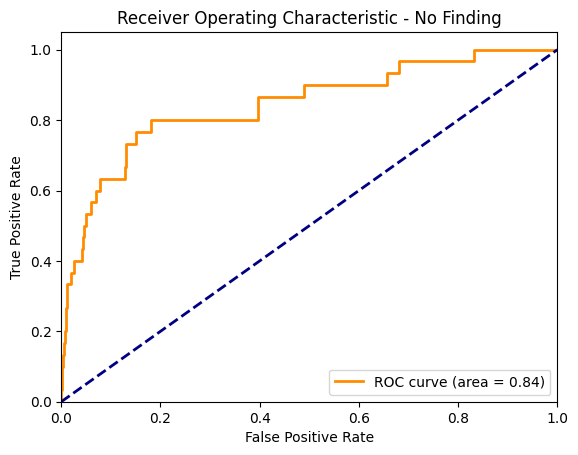

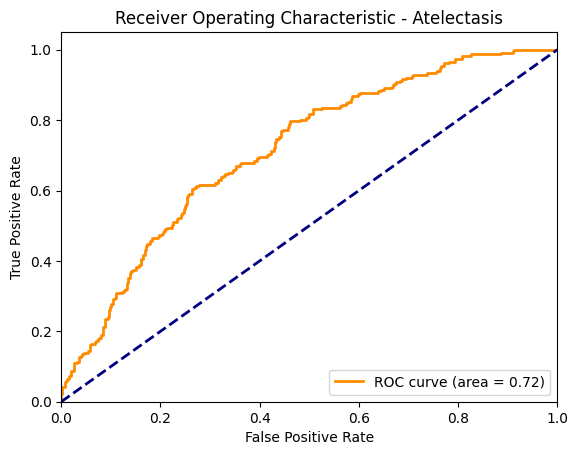

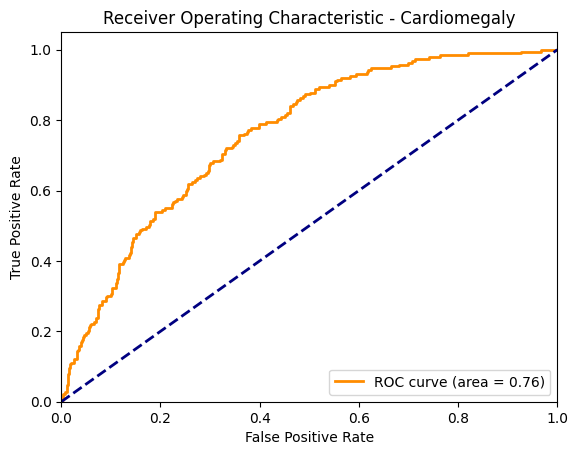

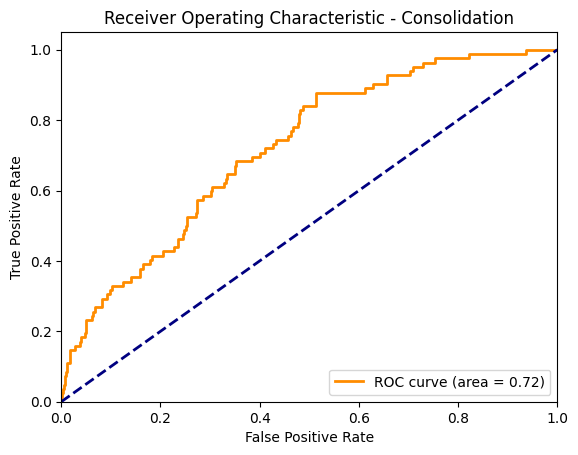

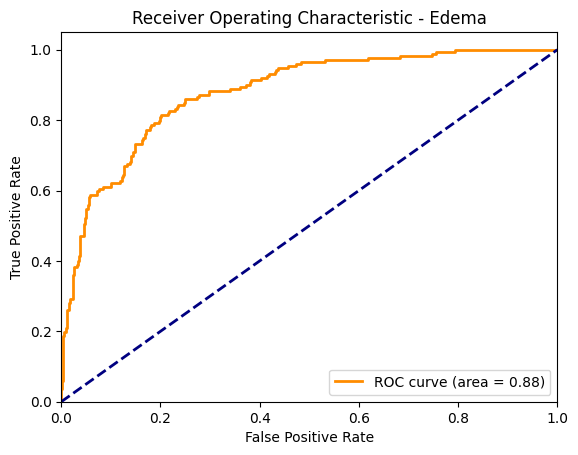

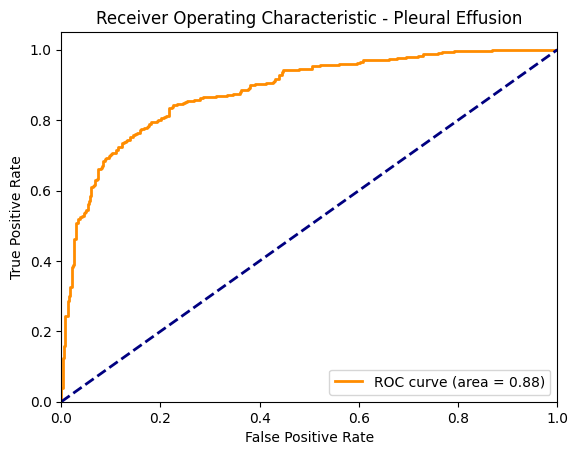

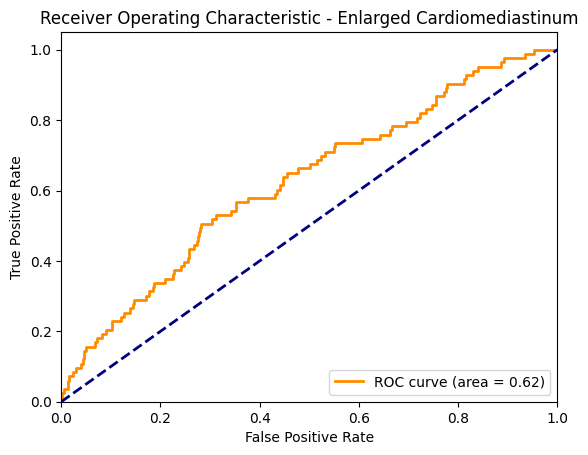

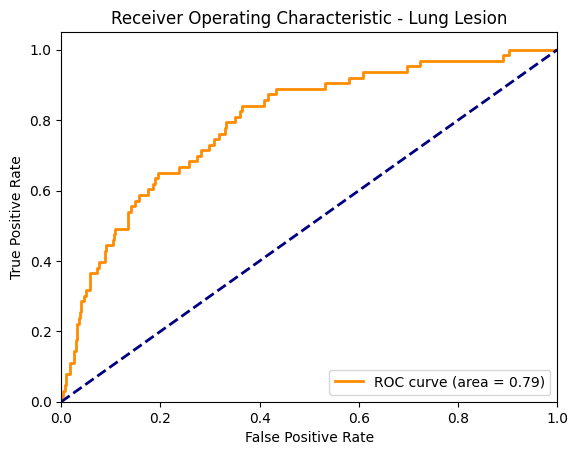

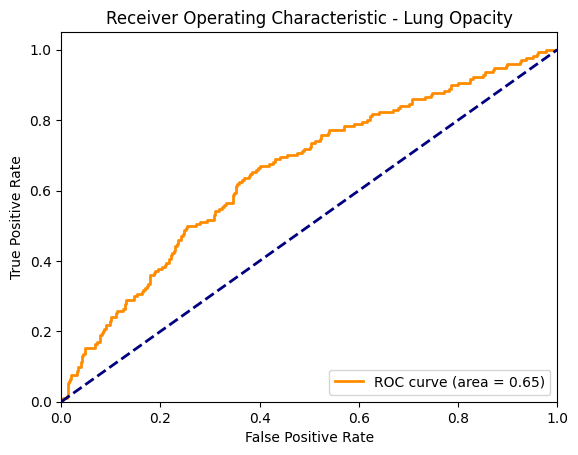

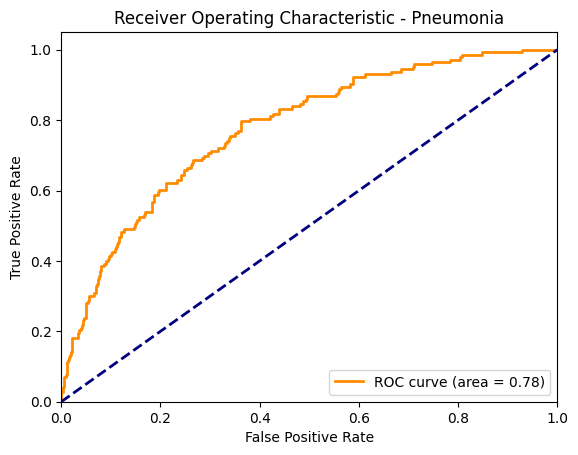

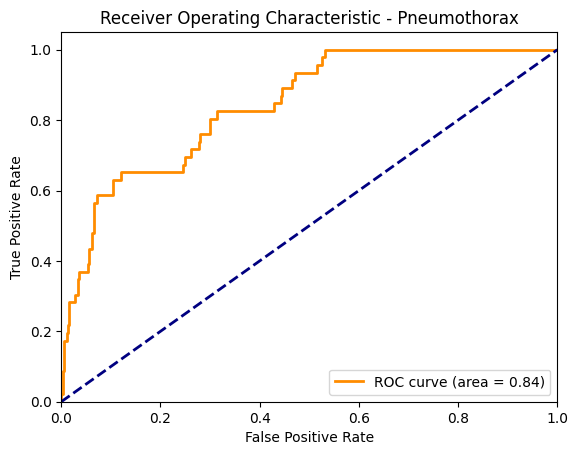

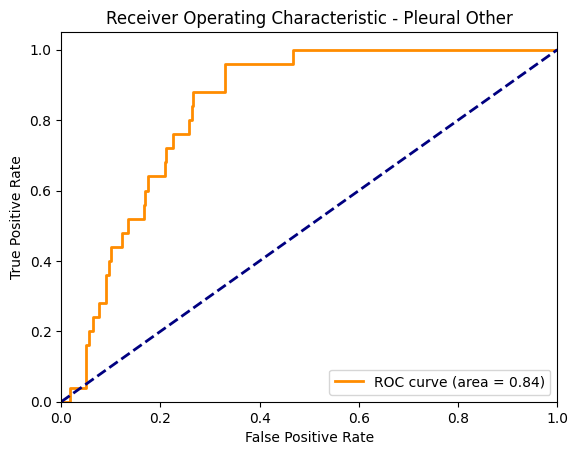

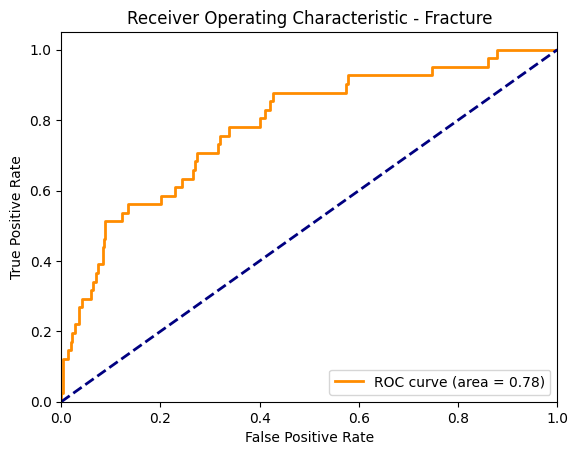

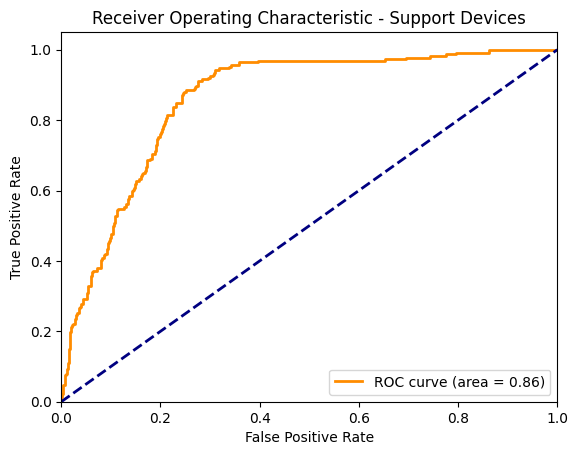

In [13]:
from torch.nn.functional import softmax
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

# 모델 초기화
use_pretrained = False
model = initialize_model(num_classes=14, use_pretrained=use_pretrained)  # num_classes=5로 설정

# 체크포인트 로드
checkpoint = torch.load('checkpoints/ChexPert/chexpert_checkpoint_epoch_4.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# 예측값과 실제값 저장할 리스트 초기화
all_labels_pos = []
all_preds_pos = []
all_probs_pos = []

# 테스트 데이터셋에 대한 예측 수행
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)  # 입력 데이터를 GPU로 이동
        labels = labels.to(device)  # 레이블을 GPU로 이동

        # ground-truth 값에서 2를 positive(1)로 설정
        labels_pos = torch.where(labels == 2, torch.tensor(1, device=device), labels)

        outputs = model(inputs)  # outputs 크기: [batch_size, 5, 3]

        # 각 레이블에 대해 positive(p1)에 대한 softmax 적용
        probs = []
        for i in range(14):  # 14개의 레이블에 대해 수행
            prob = softmax(outputs[:, i, :], dim=1)  # 각 레이블에 대해 softmax 적용
            probs.append(prob)  # 모든 확률 저장

        preds = torch.stack(probs, dim=1)  # 각 레이블에 대한 예측 확률을 stack
        positive_probs = preds[:, :, 1]  # positive(p1)의 확률만 저장

        positive_preds = (positive_probs > 0.5).long()  # 0.5를 기준으로 binary 예측

        all_labels_pos.extend(labels_pos.cpu().numpy())
        all_preds_pos.extend(positive_preds.cpu().numpy())
        all_probs_pos.extend(positive_probs.cpu().numpy())

# 각 레이블별 평가 지표 계산
labels = [
            'No Finding', 'Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Pleural Effusion',
            'Enlarged Cardiomediastinum', 'Lung Lesion', 'Lung Opacity', 'Pneumonia', 'Pneumothorax',
            'Pleural Other', 'Fracture', 'Support Devices'
        ]

precisions_pos = []
recalls_pos = []
f1s_pos = []
accuracies_pos = []

for i in range(14):  # 각 클래스별로 평가 지표를 계산
    # Positive 평가 지표
    true_binary_pos = [label[i] for label in all_labels_pos]
    pos_pred_binary = [pred[i] for pred in all_preds_pos]
    precisions_pos.append(precision_score(true_binary_pos, pos_pred_binary, average='binary', zero_division=0))
    recalls_pos.append(recall_score(true_binary_pos, pos_pred_binary, average='binary', zero_division=0))
    f1s_pos.append(f1_score(true_binary_pos, pos_pred_binary, average='binary', zero_division=0))
    accuracies_pos.append(accuracy_score(true_binary_pos, pos_pred_binary))

# 각 레이블별 평가 지표 출력
for i, label in enumerate(labels[:]):  # 14개의 레이블만 확인
    print(f"{label} - Positive\n Accuracy: {accuracies_pos[i]:.4f}, Precision: {precisions_pos[i]:.4f}, Recall: {recalls_pos[i]:.4f}, F1-Score: {f1s_pos[i]:.4f}")

# ROC 곡선과 AUC 계산 및 시각화
for i in range(14):
    true_binary_pos = [label[i] for label in all_labels_pos]
    pos_probs = [prob[i] for prob in all_probs_pos]
    fpr, tpr, _ = roc_curve(true_binary_pos, pos_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {labels[i]}')
    plt.legend(loc="lower right")
    plt.show()
